_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-13 12:09:57CEST

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

sklearn: 1.6.1

scipy     : 1.15.2
matplotlib: 3.10.1
numpy     : 2.2.3
seaborn   : 0.13.2
pandas    : 2.2.3

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [4]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/4012369867.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [5]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


In [16]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    neuron_spikes = spikes[spikes["Neuron"] == neuron]

    # Sort data by direction and trial
    sorted_spikes = neuron_spikes.sort_values(by=["Dir", "Trial"])

    unique_dirs = sorted_spikes["Dir"].unique()

    trial_rows = []
    tick_times = []

    row_idx = 0
    for d in unique_dirs:
        dir_trials = sorted_spikes[sorted_spikes["Dir"] == d]["Trial"].unique()
        for t in dir_trials:
            spikes_in_trial = sorted_spikes[
                (sorted_spikes["Dir"] == d) & (sorted_spikes["Trial"] == t)
            ]
            trial_rows.extend([row_idx] * len(spikes_in_trial))
            tick_times.extend(spikes_in_trial["relTime"].values)
            row_idx += 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(tick_times, trial_rows, marker="|", color="black", s=30)
    plt.xlabel("Time relative to stimulus onset (s)")
    plt.ylabel("Trials sorted by Dir")
    plt.title(f"Raster plot for Neuron {neuron}")
    plt.tight_layout()
    plt.show()

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/316353664.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


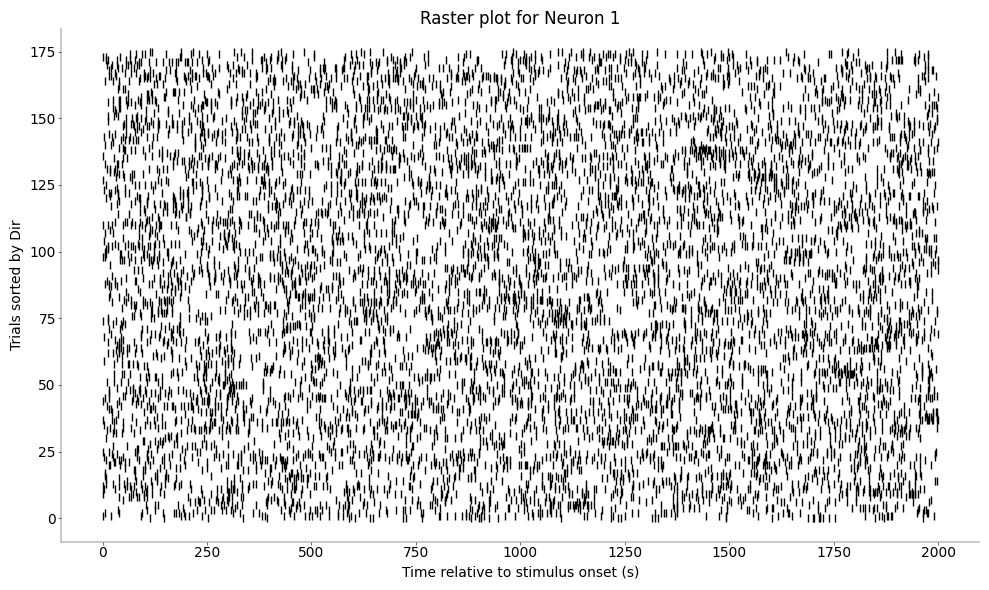

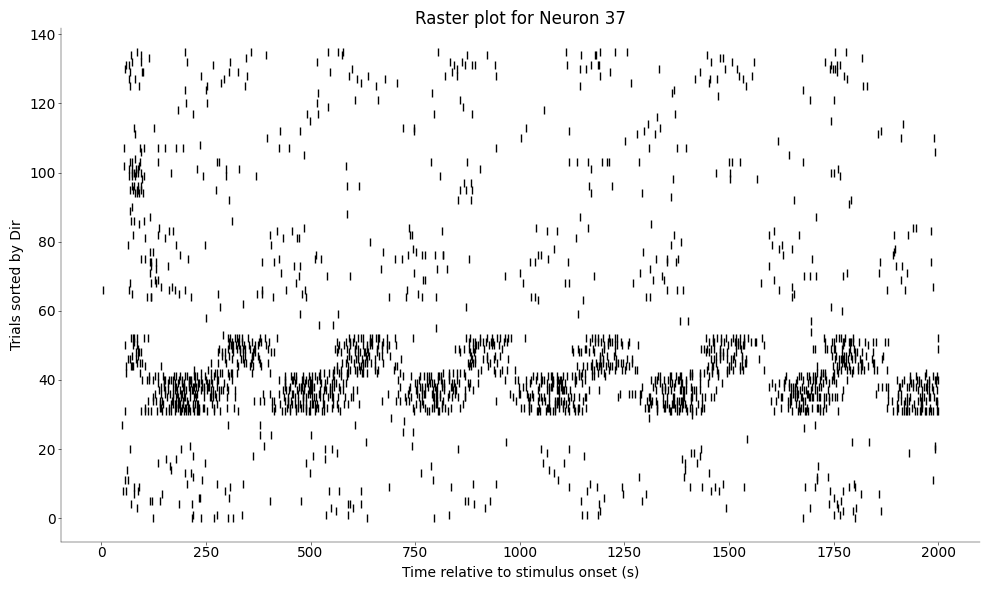

In [20]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------

# for i in range(len(spikes["Neuron"].unique())):
# plotRaster(spikes, i)

# neither is neuron 1
plotRaster(spikes, 1)
# direction is neuron 37
plotRaster(spikes, 37)
# orientation is neuron

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [ ]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Implement one of the spike rate estimates (3 pts)
    # -------------------------------------------------
    neuron_spikes = spikes[spikes["Neuron"] == neuron]

    t_min = 0
    t_max = 2000
    bin_width = 50  # in ms

    # Get unique directions
    dirs = sorted(neuron_spikes["Dir"].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(dirs)))

    # define bins
    bins = np.arange(t_min, t_max + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width / 2

    # Plot
    plt.figure(figsize=(12, 8))

    for idx, dir in enumerate(dirs):
        dir_spikes = neuron_spikes[neuron_spikes["Dir"] == dir]

        trials = dir_spikes["Trial"].unique()
        n_trials = len(trials)

        psth_counts = np.zeros(len(bins) - 1)

        for trial in trials:
            trial_spikes = dir_spikes[dir_spikes["Trial"] == trial]["relTime"].values
            counts, _ = np.histogram(trial_spikes, bins)
            psth_counts += counts

        # Average over trials and convert to firing rate (spikes/sec)
        psth_rate = (
            psth_counts / n_trials / (bin_width / 1000.0)
        )  

        # Plot
        plt.plot(bin_centers, psth_rate, label=f"Dir {dir}", color=colors[idx])

    plt.title(f"PSTH (Binned) for Neuron {neuron}")
    plt.xlabel("Time relative to stimulus onset (ms)")
    plt.ylabel("Firing rate (spikes/s)")
    plt.legend(title="Direction")
    plt.tight_layout()
    plt.show()

Plot the same 3 examples you selected in Task 1

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/2881132636.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


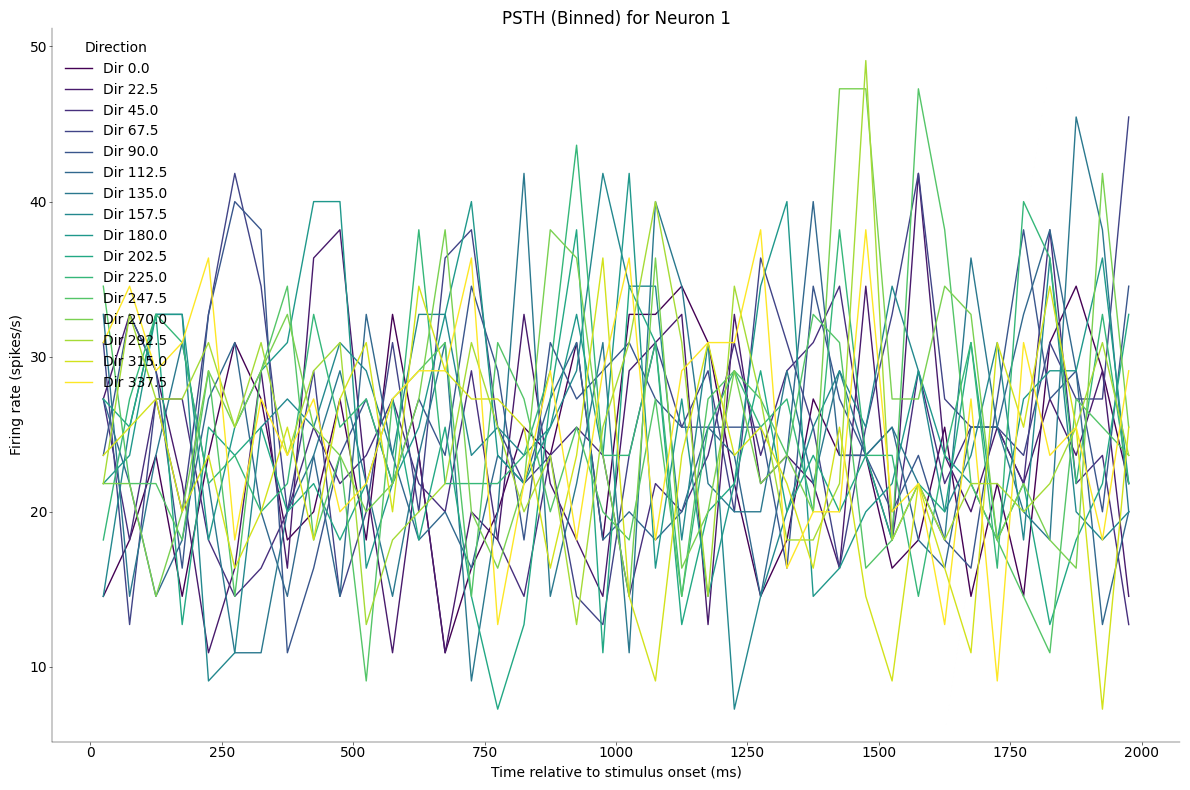

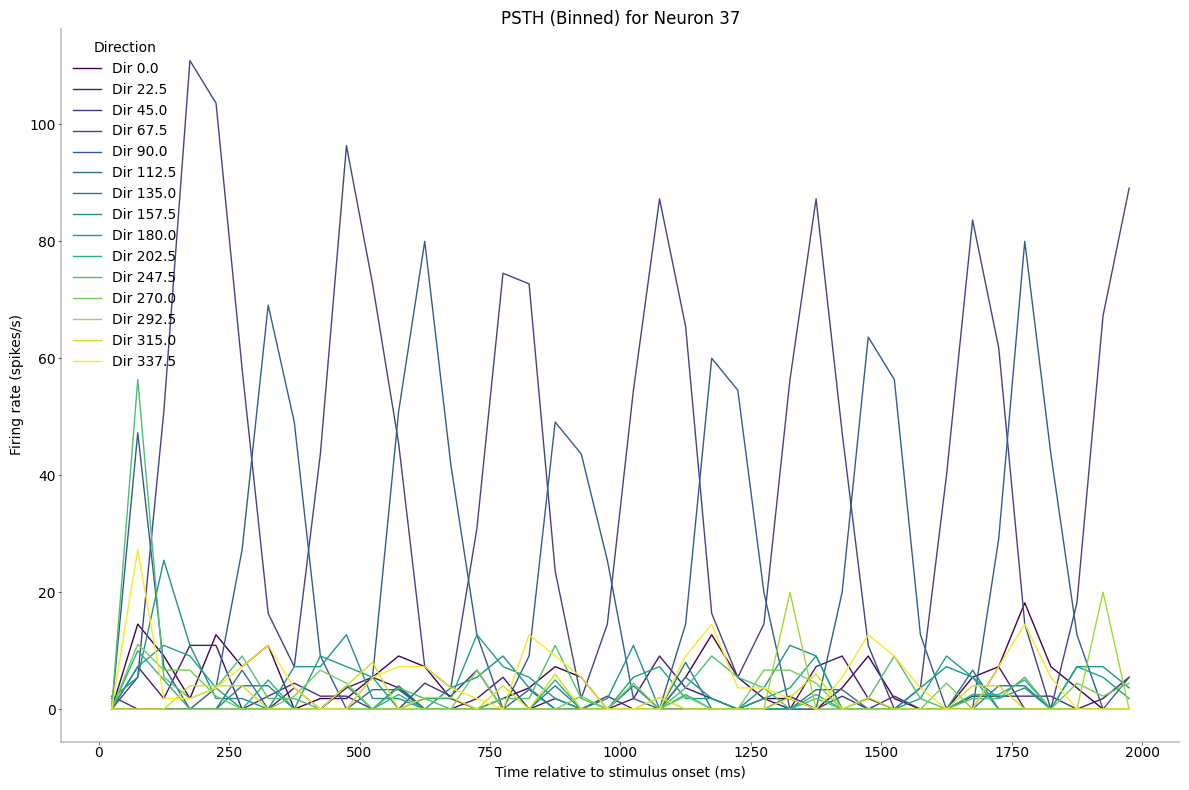

In [22]:
plotPSTH(spikes, 1)
plotPSTH(spikes, 37)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [ ]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------

    θ_rad = np.deg2rad(θ)
    ϕ_rad = np.deg2rad(ϕ)

    return np.exp(
        α + κ * (np.cos(2 * (θ_rad - ϕ_rad)) - 1) + ν * (np.cos(θ_rad - ϕ_rad) - 1)
    )

Plot the von Mises function while varying the parameters systematically.

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/1988042883.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


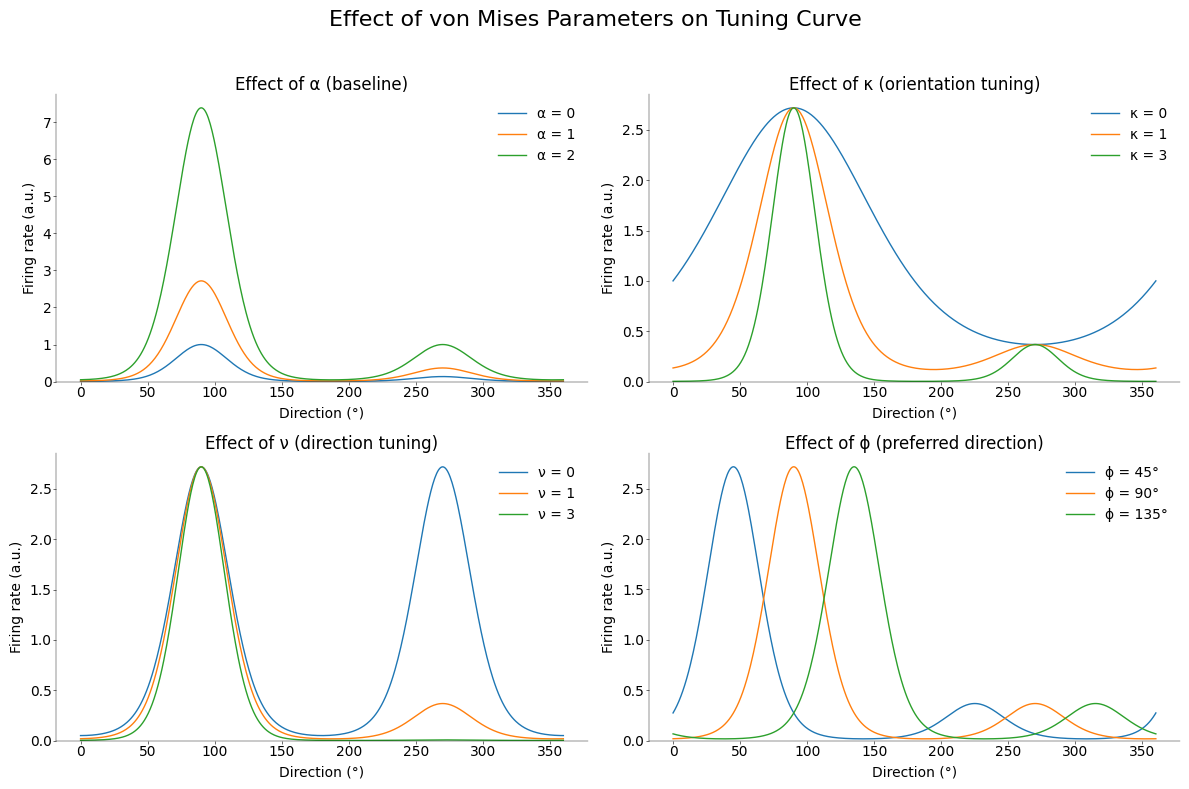

In [24]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------
θ = np.linspace(0, 360, 500)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

# 1. Vary α (baseline firing)
for α in [0, 1, 2]:
    axs[0].plot(θ, vonMises(θ, α, 2, 1, 90), label=f"α = {α}")
axs[0].set_title("Effect of α (baseline)")
axs[0].legend()

# 2. Vary κ (orientation selectivity)
for κ in [0, 1, 3]:
    axs[1].plot(θ, vonMises(θ, 1, κ, 1, 90), label=f"κ = {κ}")
axs[1].set_title("Effect of κ (orientation tuning)")
axs[1].legend()

# 3. Vary ν (direction selectivity)
for ν in [0, 1, 3]:
    axs[2].plot(θ, vonMises(θ, 1, 2, ν, 90), label=f"ν = {ν}")
axs[2].set_title("Effect of ν (direction tuning)")
axs[2].legend()

# 4. Vary φ (preferred direction)
for ϕ in [45, 90, 135]:
    axs[3].plot(θ, vonMises(θ, 1, 2, 1, ϕ), label=f"ϕ = {ϕ}°")
axs[3].set_title("Effect of ϕ (preferred direction)")
axs[3].legend()

for ax in axs:
    ax.set_xlabel("Direction (°)")
    ax.set_ylabel("Firing rate (a.u.)")
    ax.set_ylim(bottom=0)

plt.suptitle("Effect of von Mises Parameters on Tuning Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
from scipy.optimize import curve_fit


def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------

    # Get unique directions in sorted order
    unique_dirs = np.sort(np.unique(dirs))

    # Compute mean spike counts per direction
    mean_counts = np.array([counts[dirs == d].mean() for d in unique_dirs])

    # ------------------------------------------------------------
    # Fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------

    # Initial parameter guess: [α, κ, ν, ϕ]
    α0 = np.log(np.max(mean_counts) + 1e-3)
    ϕ0 = unique_dirs[np.argmax(mean_counts)]
    p0 = [α0, 1.0, 1.0, ϕ0]

    try:
        popt, _ = curve_fit(vonMises, unique_dirs, mean_counts, p0=p0, maxfev=5000)
    except RuntimeError:
        print("Fitting failed.")
        return np.array([np.nan, np.nan, np.nan, np.nan])

    # --------------------------------------------
    # Plot the data and fitted tuning curve (1 pt)
    # --------------------------------------------

    if show:
        θ_fit = np.linspace(0, 360, 500)
        fit_curve = vonMises(θ_fit, *popt)

        plt.figure(figsize=(8, 5))
        plt.plot(θ_fit, fit_curve, label="von Mises Fit", color="red")
        plt.plot(unique_dirs, mean_counts, "o", label="Mean Spike Count", color="blue")

        for d in unique_dirs:
            jitter = np.random.uniform(-2, 2, size=np.sum(dirs == d))
            plt.scatter(d + jitter, counts[dirs == d], color="gray", alpha=0.4)

        plt.title("Tuning Curve Fit")
        plt.xlabel("Direction (°)")
        plt.ylabel("Spike Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return popt

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [ ]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/2318912062.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


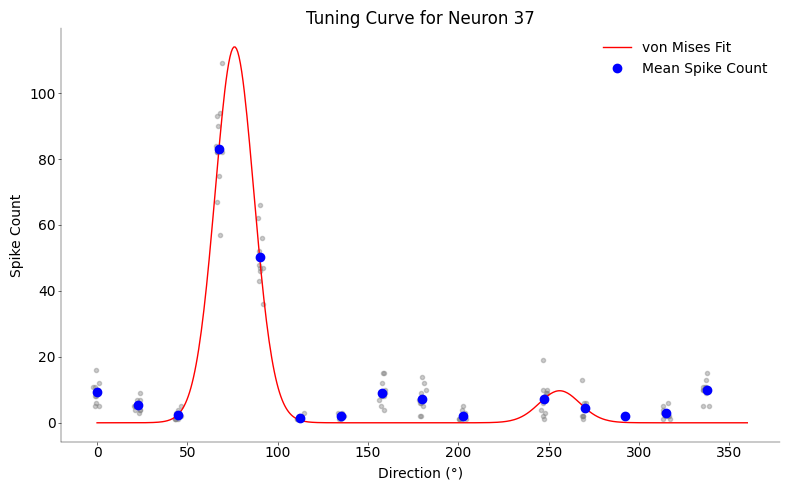

In [27]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------

neuron_id = 37

neuron_data = spikes[spikes["Neuron"] == neuron_id]
stim_spikes = neuron_data[neuron_data["stimPeriod"] == True]

# Count spikes per trial per direction
spike_counts = (
    stim_spikes.groupby(["Trial", "Dir"])["relTime"]
    .count()
    .reset_index()
    .rename(columns={"relTime": "spikeCount"})
)

all_trials = neuron_data[["Trial", "Dir"]].drop_duplicates()
spike_counts = pd.merge(
    all_trials, spike_counts, on=["Trial", "Dir"], how="left"
).fillna(0)

counts = spike_counts["spikeCount"].values
dirs = spike_counts["Dir"].values

# Mean spike count per direction
unique_dirs = np.sort(np.unique(dirs))
mean_counts = np.array([counts[dirs == d].mean() for d in unique_dirs])

α0 = np.log(np.max(mean_counts) + 1e-3)
ϕ0 = unique_dirs[np.argmax(mean_counts)]
p0 = [α0, 1.0, 1.0, ϕ0]

try:
    popt, _ = curve_fit(vonMises, unique_dirs, mean_counts, p0=p0, maxfev=5000)
except RuntimeError:
    print("Fitting failed.")
    popt = [np.nan, np.nan, np.nan, np.nan]

# ---- Plotting ----
θ_fit = np.linspace(0, 360, 500)
fit_curve = vonMises(θ_fit, *popt)

plt.figure(figsize=(8, 5))
plt.plot(θ_fit, fit_curve, label="von Mises Fit", color="red")
plt.plot(unique_dirs, mean_counts, "o", label="Mean Spike Count", color="blue")

# Add all individual trials (with jitter for visibility)
for d in unique_dirs:
    jitter = np.random.uniform(-2, 2, size=np.sum(dirs == d))
    plt.scatter(d + jitter, counts[dirs == d], color="gray", alpha=0.4)

plt.title(f"Tuning Curve for Neuron {neuron_id}")
plt.xlabel("Direction (°)")
plt.ylabel("Spike Count")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/ph/rzf8mr4124l1sb8_c8_qsrfr0000gn/T/ipykernel_66742/1733443880.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


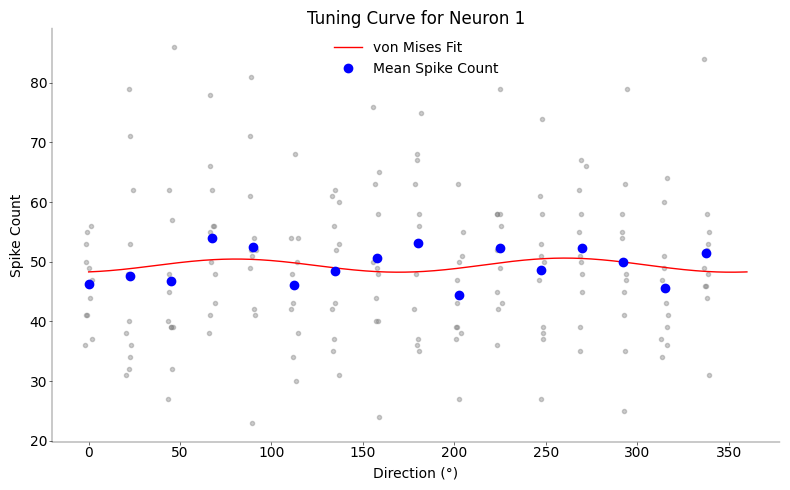

In [28]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------

neuron_id = 1

neuron_data = spikes[spikes["Neuron"] == neuron_id]
stim_spikes = neuron_data[neuron_data["stimPeriod"] == True]

# Count spikes per trial per direction
spike_counts = (
    stim_spikes.groupby(["Trial", "Dir"])["relTime"]
    .count()
    .reset_index()
    .rename(columns={"relTime": "spikeCount"})
)

all_trials = neuron_data[["Trial", "Dir"]].drop_duplicates()
spike_counts = pd.merge(
    all_trials, spike_counts, on=["Trial", "Dir"], how="left"
).fillna(0)

counts = spike_counts["spikeCount"].values
dirs = spike_counts["Dir"].values

# Mean spike count per direction
unique_dirs = np.sort(np.unique(dirs))
mean_counts = np.array([counts[dirs == d].mean() for d in unique_dirs])

α0 = np.log(np.max(mean_counts) + 1e-3)
ϕ0 = unique_dirs[np.argmax(mean_counts)]
p0 = [α0, 1.0, 1.0, ϕ0]

try:
    popt, _ = curve_fit(vonMises, unique_dirs, mean_counts, p0=p0, maxfev=5000)
except RuntimeError:
    print("Fitting failed.")
    popt = [np.nan, np.nan, np.nan, np.nan]

# ---- Plotting ----
θ_fit = np.linspace(0, 360, 500)
fit_curve = vonMises(θ_fit, *popt)

plt.figure(figsize=(8, 5))
plt.plot(θ_fit, fit_curve, label="von Mises Fit", color="red")
plt.plot(unique_dirs, mean_counts, "o", label="Mean Spike Count", color="blue")

# Add all individual trials (with jitter for visibility)
for d in unique_dirs:
    jitter = np.random.uniform(-2, 2, size=np.sum(dirs == d))
    plt.scatter(d + jitter, counts[dirs == d], color="gray", alpha=0.4)

plt.title(f"Tuning Curve for Neuron {neuron_id}")
plt.xlabel("Direction (°)")
plt.ylabel("Spike Count")
plt.legend()
plt.tight_layout()
plt.show()

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    
    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)


    if show:
        # add plotting code here
        pass

Show null distribution for the example cell:

In [ ]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------

Test all cells for orientation and direction tuning

In [ ]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning. 
# Which ones are selective? (0.5 pts)
# --------------------------------------------------

Number of direction tuned neurons:

Number of orientation tuned neurons: